# 1. 构建网络

论文名称：《Event-based High Dynamic Range Image and Very High Frame Rate Video Generation using Conditional Generative Adversarial Networks》

## 1.1 生成模型

In [1]:
import torch
import torch.nn as nn

class HDRGen(nn.Module):
    def __init__(self,dropout = 0.5):
        super(HDRGen,self).__init__()
        self.Encoder1 = nn.Sequential(
            # input(3，256，256)
            nn.Conv2d(3,64,3,stride=2,padding=1),
            nn.InstanceNorm2d(3),
            nn.ReLU()
        )
        self.Encoder2=nn.Sequential(
            #input(64,128,128)
            nn.Conv2d(64,128,3,stride=2,padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )
        self.Encoder3 = nn.Sequential(
            #input(128,64,64)
            nn.Conv2d(128,256,3,stride=2,padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )
        self.Encoder4 = nn.Sequential(
            #input(256,32,32)
            nn.Conv2d(256,512,3,stride=2,padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU()
        )
        self.Encoder5=nn.Sequential(
            #input(512,16,16)
            nn.Conv2d(512,512,3,stride=2,padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        self.Encoder6=nn.Sequential(
            #input(512,8,8)
            nn.Conv2d(512,512,3,stride=2,padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        self.Encoder7=nn.Sequential(
            #Input(512,4,4)
            nn.Conv2d(512,512,3,stride=2,padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        self.Encoder8=nn.Sequential(
            #input(512,2,2)
            nn.Conv2d(512,512,2,stride=2),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        self.Decoder8 = nn.Sequential(
            nn.ConvTranspose2d(512,512,2,stride=2),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        # 这里第一次使用反卷积，注意，从低纬向高纬进行反卷积往往不是一一对应的，为了使反卷积和卷积对应起来，通常来讲,padding = (ksize-1)/2 ,output_padding=stride-1
        self.Decoder7 = nn.Sequential(
            nn.ConvTranspose2d(512,512,3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        self.Decoder6 = nn.Sequential(
            nn.ConvTranspose2d(512,512,3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        self.Decoder5=nn.Sequential(
            nn.ConvTranspose2d(512,512,3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        self.Decoder4 = nn.Sequential(
            nn.ConvTranspose2d(512,256,3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        self.Decoder3 = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU()
        )
        self.Decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )
        self.Decoder1 = nn.Sequential(
            nn.ConvTranspose2d(64,1,3,stride=2,padding=1,output_padding=1),
            nn.Tanh()
        )
    def forward(self,frame):
        #input(N,3,256,256)
        encoder1 = self.Encoder1(frame)
        encoder2 = self.Encoder2(encoder1)
        encoder3 = self.Encoder3(encoder2)
        encoder4 = self.Encoder4(encoder3)
        encoder5 = self.Encoder5(encoder4)
        encoder6 = self.Encoder6(encoder5)
        encoder7 = self.Encoder7(encoder6)
        encoder8 = self.Encoder8(encoder7)
        
        decoder8 = self.Decoder8(encoder8)+encoder7
        decoder7 = self.Decoder7(decoder8)+encoder6
        decoder6 = self.Decoder6(decoder7)+encoder5
        decoder5 = self.Decoder5(decoder6)+encoder4
        decoder4 = self.Decoder4(decoder5)+encoder3
        decoder3 = self.Decoder3(decoder4)+encoder2
        decoder2 = self.Decoder2(decoder3)+encoder1
        output = self.Decoder1(decoder2)
        return output
        

## 1.2 数据导入

In [2]:
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2

class Datain(Dataset):
    def __init__(self,InputPath):
        self.InputPath = InputPath
        self.FileList=os.listdir(self.InputPath)
        self.Length = len(self.FileList)
        
    def Float2Image(self,InputFloat):
        Output = 127.5*InputFloat+127.5
        return Output.astype(int)

    def Image2Float(self,InputImage):
        InputImage = InputImage.astype(float)
        return 2*InputImage/255 -1
    
    
    def __getitem__(self,index):
        Image = cv2.imread(os.path.join(self.InputPath,self.FileList[index]))
        Image = cv2.resize(Image,(512,256),interpolation=cv2.INTER_CUBIC)
#         plt.figure()
#         plt.imshow(Image)
        Image = self.Image2Float(Image)
#         Image = self.Float2Image(Image)
#         plt.figure()
#         plt.imshow(Image)
        Image = torch.tensor(Image,dtype = torch.float32)
        Input,Output = Image.chunk(2,1)
        Output,_,_ = Output.chunk(3,2)
        return Input.permute(2,0,1),Output.permute(2,0,1)
    def __len__(self):
        return self.Length
    
TestData = Datain('Sim_EBS_test')
print(TestData[100][0].shape,TestData[78][1].shape)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


# 2 数据导入并运行

G model load successfully


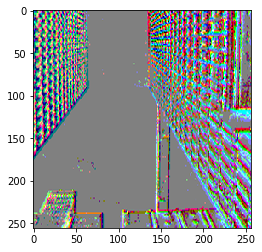

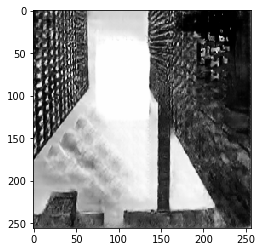

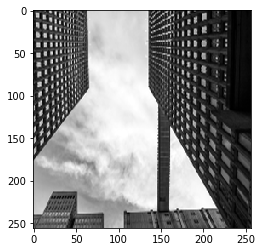

In [5]:
import os
from torch.utils.data import DataLoader

G = HDRGen()

G.load_state_dict(torch.load('GenModel.pkl'))
print('G model load successfully')

G.cuda()
Input = DataLoader(dataset=TestData,batch_size=1,shuffle=True)
G.eval()

def showTensor(Image,type=1):
    if type == 1:
        Image = torch.cat((Image,Image,Image),dim=1)
        Image = Image.permute(0,2,3,1)
        Image = Image.cpu().detach().numpy()
        Image = TestData.Float2Image(Image[0])
        plt.figure()
        plt.imshow(Image)
    elif type==0:
        Image = Image.permute(0,2,3,1)
        Image = Image.cpu().detach().numpy()
        Image = TestData.Float2Image(Image[0])
        plt.figure()
        plt.imshow(Image)

for index,data in enumerate(Input):
    Image = G(data[0].cuda())
    showTensor(data[0],0)
    showTensor(Image)
    showTensor(data[1])
    if index == 0:
        break

